In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ks_2samp, mannwhitneyu
import sys

sys.path.append('~/GitHub/IP-research/Stats_Analysis/toolbox')
import stats_helper_files as stat

# Inputs

external_csv = r"/home/andris/GitHub/data/school_ext_data.csv"
internal_csv = r"/home/andris/GitHub/data/school_clk_data.csv"


## Data preparation

In [48]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)
print('Total number of schools in external spreadsheet:',len(df_ext))

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)
print('Total number of schools in internal spreadsheet:',len(df_int))

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))
print('Number of schools after joining:',len(df))

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

# Select the schools that have provide all science courses in all years
df = df[(df.filter(regex='Entries') > 0).all(axis=1)]
print('Number of schools that had all science courses:',len(df))


Total number of schools in external spreadsheet: 2776
Total number of schools in internal spreadsheet: 1238
Number of schools after joining: 2776
Number of schools that had all science courses: 899


In [49]:
# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

# Defining it relative to the mean

for item in qu:
    df['exam_improv_2013-2014_' + item] = (df['exam_score|2014_'+item]/df['exam_score|2014_'+item].mean() - df['exam_score|2013_'+item]/df['exam_score|2013_'+item].mean())

for item in qu:
    df['exam_improv_2013-2016_' + item] = (df['exam_score|2016_'+item]/df['exam_score|2016_'+item].mean() - df['exam_score|2013_'+item]/df['exam_score|2013_'+item].mean())

# Student activity
df['std_q_cor'] =  (df.filter(regex='_cor_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['std_ratio'] =  (df['user_id_std']/df['Entries|2016_Physics']).fillna(0) 

# Trying a combination
df['combo'] = (df['std_q_cor']/df['std_q_cor'].mean()) + (df['std_ratio']/df['std_ratio'].mean())

## Performing Sensitivity Tests

In [54]:
bins = [-0.1, 0, 1, 1000]
cut_off_array = np.array(range(1,500))*0.01
df_score = stat.sensitivity_on_bin(df, 'combo', df.filter(regex='exam_improv').columns, bins, ['Inactive','Semi-active','Active'], 
                                   cut_off_array,test_type=ks_2samp)


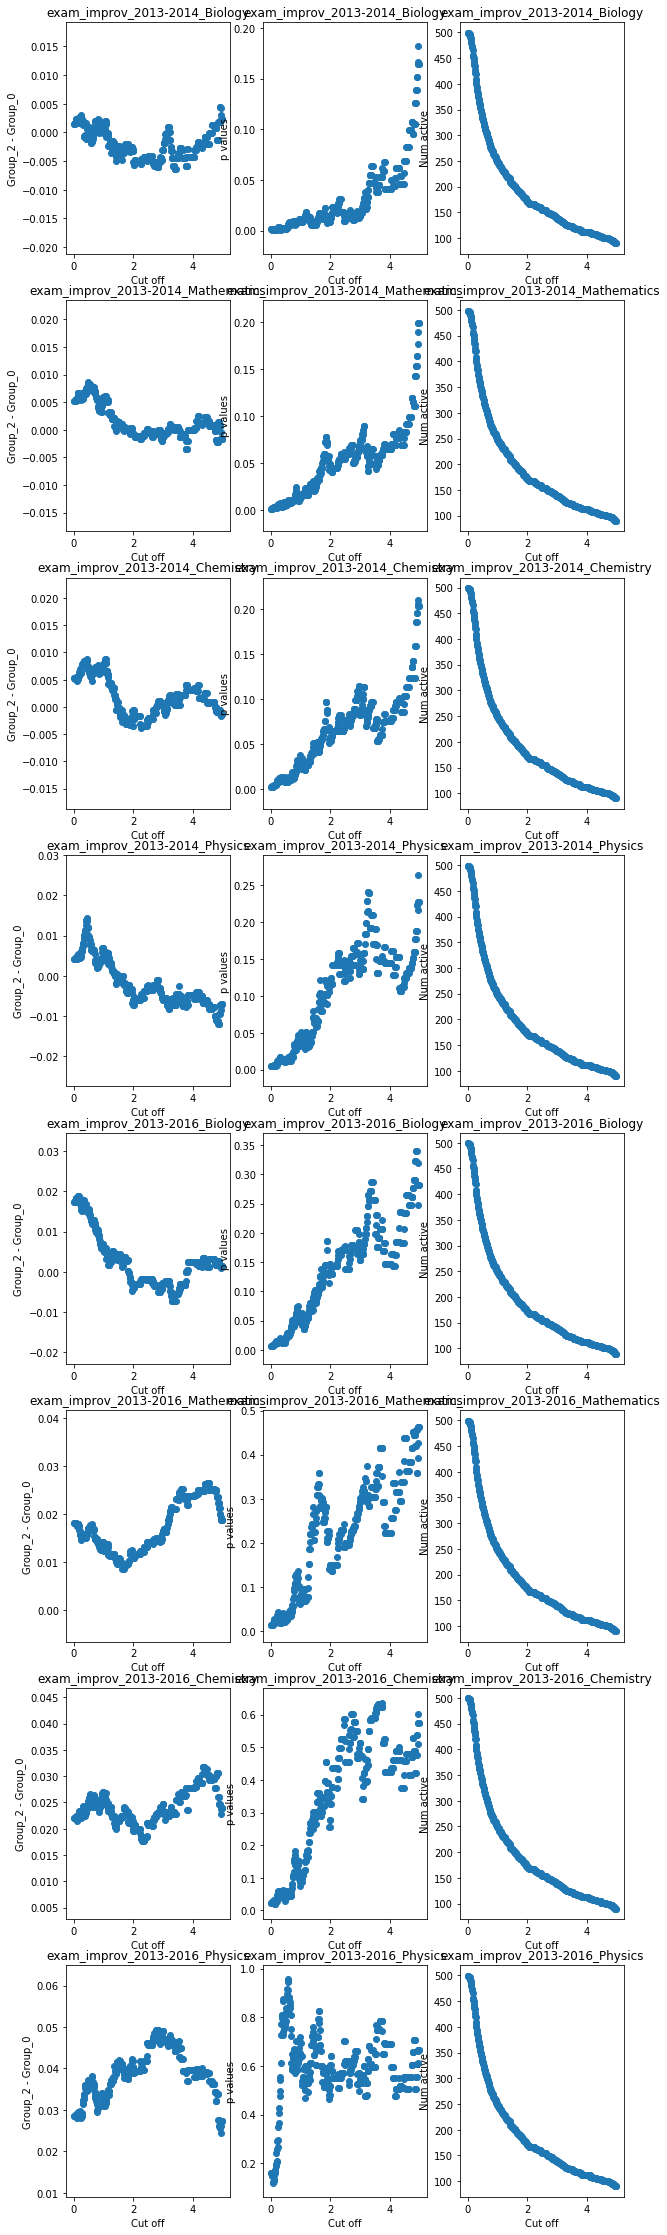

In [55]:
stat.plot_sensitivity(df_score,df_score['Key'].unique(), ['Group_2 - Group_0','p values','Num active'])

In [52]:
df_score.index.unique()

Index(['exam_improv_2013-2014_Biology', 'exam_improv_2013-2014_Mathematics',
       'exam_improv_2013-2014_Chemistry', 'exam_improv_2013-2014_Physics',
       'exam_improv_2013-2016_Biology', 'exam_improv_2013-2016_Mathematics',
       'exam_improv_2013-2016_Chemistry', 'exam_improv_2013-2016_Physics'],
      dtype='object')